In [27]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [28]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/synesthetes/participants.csv"
embeddings_subpath = "synesthetes_random_embeddings/full_embeddings.csv"
ukb_embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isSynesthete_without_residualization.csv"
label = "isSynesthete"
max_iter = 2000
cv = 3

In [29]:
participants = pd.read_csv(participants_file, index_col=0)


In [30]:
participants.head()

,isSynesthete,NOM,DDN,IRM name,Date IRM,Âge,Sexe,Latéralité,Remarques,Code BV,Unnamed: 9,2=femme – 1=homme,0=droitier – 1=gaucher
participant_id,,,,,,,,,,,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,SARR,10/8/1996,Sujet01,28/2/2023,26.569863,2,0,NaN,3,NaN,NaN,NaN
mv_SYNESTHEX_S_Session1_S2_T1w,1,LEFR,14/12/1950,Sujet02,9/3/2023,72.282192,2,0,NaN,S,NaN,NaN,NaN
mv_SYNESTHEX_M_Session1_S2_T1w,1,FERN,NaN,Sujet03,NaN,23.680000,1,0,NaN,M,NaN,NaN,NaN
mv_SYNESTHEX_K_Session1_S2_T1w,1,DERO,27/6/1997,Sujet04,21/10/2023,26.334247,1,0,NaN,K,NaN,NaN,NaN
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,DECH,NaN,Sujet05,NaN,21.110000,2,1,NaN,Sujet20,NaN,NaN,NaN


In [31]:
participants = participants[["isSynesthete", "Sexe", "Latéralité"]]

In [32]:
# participants[:] = participants.sample(frac=1).values

In [33]:
participants

,isSynesthete,Sexe,Latéralité
participant_id,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,2,0
mv_SYNESTHEX_S_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_M_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_K_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,2,1
mv_SYNESTHEX_Y_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_Sujet25_Session1_S2_T1w,1,1,1
mv_SYNESTHEX_G_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_D_Session1_S2_T1w,1,2,0


array([[<Axes: title={'center': 'isSynesthete'}>,
        <Axes: title={'center': 'Sexe'}>],
       [<Axes: title={'center': 'Latéralité'}>, <Axes: >]], dtype=object)

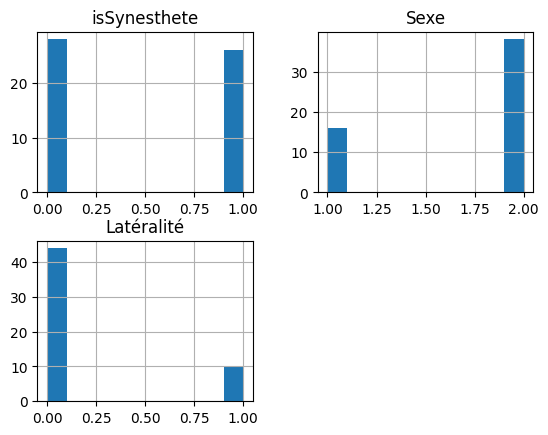

In [34]:
participants.hist()

In [35]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [36]:
model_paths = get_model_paths(path_champollion)

In [37]:
models_df = pd.DataFrame({"path":model_paths})

In [38]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [39]:
def compute(model_path, random_state):
    global embeddings
    global participants
    global results, X, Y, df2
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    ukb_emb = pd.read_csv(f"{model_path}/{ukb_embeddings_subpath}", index_col=0)
    
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]

    # Makes PCA on UkBioBank
    # print(ukb_emb.shape)
    pca = PCA(n_components=5)
    pca.fit(ukb_emb)

    # Transforms in synesthete dataset
    df2 = pd.DataFrame(pca.transform(X))
    df2.index = X.index

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue

    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [40]:
participants.dtypes

isSynesthete    int64
Sexe            int64
Latéralité      int64
dtype: object

In [41]:
result = []
for random_state in range(1):

    # Computes AUC
    for model_path in model_paths:
        result.append(compute(model_path, random_state))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
1.619498759398412
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
1.3415412622798757
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
1.1791435396921892
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
1.625582594900981
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
0.5719204702385348
Treating S.T.s.-S.GSM._left: STs-SGSM_left/13-57-40_59 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STs-SGSM_left/13-57-

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           isSynesthete   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2.013
Date:                Mon, 07 Oct 2024   Prob (F-statistic):             0.0936
Time:                        11:18:08   Log-Likelihood:                -34.015
No. Observations:                  54   AIC:                             80.03
Df Residuals:                      48   BIC:                             91.96
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4720      0.073      6.450      0.000       0.325       0.619
0             -0.0006      0.000     -1.619      0.112      -0.001       0.000
1              0.0001      0.000      0.385      0.702      -0.001       0.001
2              0.0005      0.000      1.155      0.254      -0.000       0.001
3              0.0011      0.000      2.192      0.033    8.83e-05       0.002
4              0.0003      0.000      0.697      0.489      -0.001       0.001
==============================================================================
Omnibus:                       24.607   Durbin-Watson:                   0.458
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.201
Skew:                           0.108   Prob(JB):                        0.122
Kurtosis:                       1.651   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [44]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,1.619499,0.172913,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,1.341541,0.263104,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,1.179144,0.333295,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,1.625583,0.171304,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.571920,0.721094,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
93,S.C.-S.Po.C._left,1.438570,0.227657,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...
94,S.C.-S.Po.C._left,1.763193,0.138467,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...
95,S.C.-S.Po.C._left,1.720267,0.148010,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...
96,S.C.-S.Po.C._left,1.917737,0.108752,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...


In [45]:
df['side'] = df['region'].str.split('_').str[-1]

In [46]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,1.619499,0.172913,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,1.341541,0.263104,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,1.179144,0.333295,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,1.625583,0.171304,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.571920,0.721094,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
93,S.C.-S.Po.C._left,1.438570,0.227657,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...,left
94,S.C.-S.Po.C._left,1.763193,0.138467,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...,left
95,S.C.-S.Po.C._left,1.720267,0.148010,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...,left
96,S.C.-S.Po.C._left,1.917737,0.108752,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...,left


In [58]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05/56), color='black', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [59]:
0.05/56

0.0008928571428571429

In [60]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
10,S.Po.C._left,3.741622,0.006108,22-10-40_0,SPoC_left/22-10-40_0,/neurospin/dico/data/deep_folding/current/mode...,left
12,S.Po.C._left,3.645237,0.007093,10-18-59_2,SPoC_left/10-18-59_2,/neurospin/dico/data/deep_folding/current/mode...,left
16,S.Po.C._left,3.117057,0.016233,18-08-26_0,SPoC_left/18-08-26_0,/neurospin/dico/data/deep_folding/current/mode...,left
11,S.Po.C._left,3.083722,0.017111,15-39-28_1,SPoC_left/15-39-28_1,/neurospin/dico/data/deep_folding/current/mode...,left
13,S.Po.C._left,2.820814,0.025953,15-39-28_0,SPoC_left/15-39-28_0,/neurospin/dico/data/deep_folding/current/mode...,left
...,...,...,...,...,...,...,...
67,S.F.median-S.F.pol.tr.-S.F.sup._left,0.198043,0.961726,18-09-26_0,SFmedian-SFpoltr-SFsup_left/18-09-26_0,/neurospin/dico/data/deep_folding/current/mode...,left
52,F.I.P._left,0.188840,0.965428,14-56-46_4,FIP_left/14-56-46_4,/neurospin/dico/data/deep_folding/current/mode...,left
39,F.C.L.p.-S.GSM._right,0.129818,0.984853,11-40-20_0,FCLp-SGSM_right/11-40-20_0,/neurospin/dico/data/deep_folding/current/mode...,right
43,F.P.O.-S.Cu.-Sc.Cal._right,0.123161,0.986551,20-03-37_1,FPO-SCu-ScCal_right/20-03-37_1,/neurospin/dico/data/deep_folding/current/mode...,right


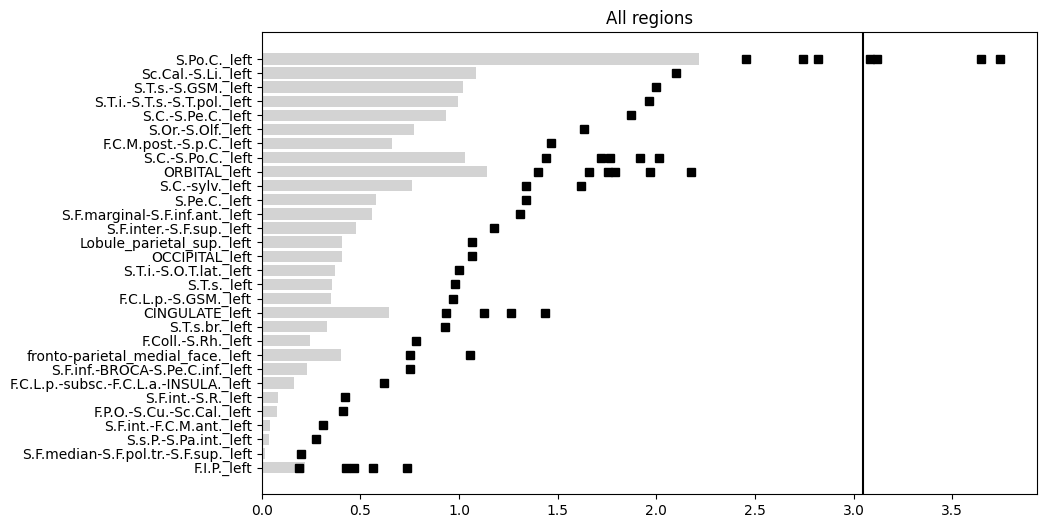

In [61]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

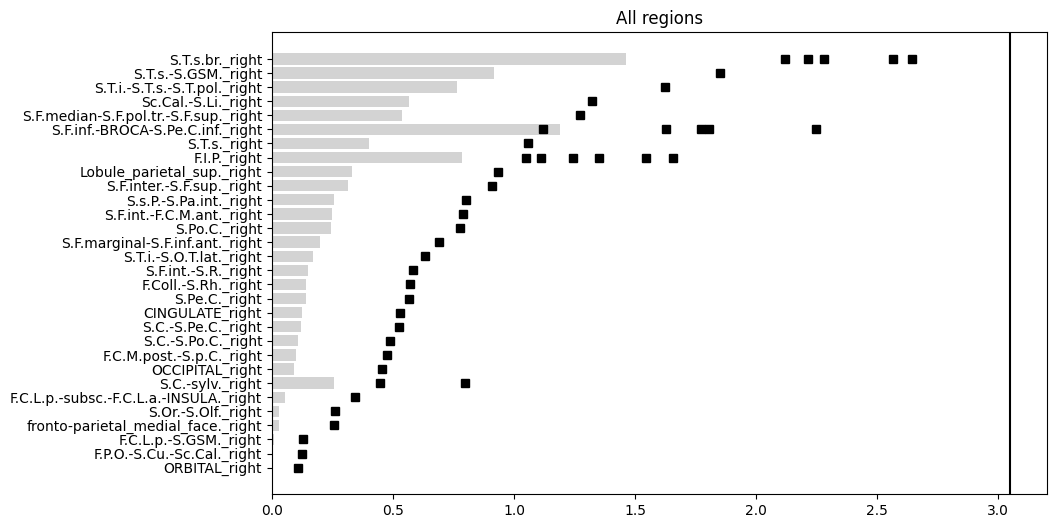

In [62]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [52]:
# df.to_csv(output_filename)